This is a dev notebook of a solver for matter effect.

In [4]:
%matplotlib inline
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [5]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import ode
import matplotlib.pylab as plt

In [6]:
import neuosc as no

### Expectations

Before any calculation, I have calculated the results using Mathematica. The system to be solved is

$$
i \partial_x 
$$

The parameters used before are (in units of $\mathrm{MeV}$ or $\mathrm{MeV}^2$):

$\theta_v = \theta_{13} = 0.153077$

$\delta m^2 = \delta m_{13}^2 = 2.6*10^{-15}$

$\omega_v=6.5*10^{-17}$

$\lambda_0 = 0.5 \lambda_{MSW} = 3.09888*10^{-17}$

$\omega_m = 3.66619*10^{-17}$

$\theta_m = 0.162129$

$k_1= 1; k_2 = 1/90$

$\{A_1,A_2\} = \{0.0000358865, 0.0648636\}$ in units of omegam


Using these parameters,

1. Only one frequency case the oscillation weavelength is of the order $\hat x = \omega_m x\sim 1000000$
2. IF we are going to see the FULL oscillation, we expect a calculation range of $\hat x \sim 10^8$.

In [311]:
endpoint = 50000000; # integration range
dx = 10.0; # step size
lam0 = 0.845258; # in unit of omegam, omegam = 3.66619*10^-17
dellam = np.array([0.0000358865, 0.0648636]); # deltalambda/omegam
ks = [1.0,1.0/90]; # two k's
thm = 0.162129; # theta_m

In [312]:
psi0, x0 = [1.0+0.j, 0.0], 0

xlin = np.arange(dx,endpoint+1*dx, dx)

psi = np.zeros([len(xlin)  , 2], dtype='complex_')

def hamiltonian(x, deltalambda, k, thetam):
    
#    return (-0.5 + 0.5 * deltalambda * np.sin(k*x) * np.cos(2*thetam) ) * no.pauli_matrices(3) - 0.5 * deltalambda * np.sin(k*x) * np.sin(2*thetam) * no.pauli_matrices(1)     # This hamiltonian is not working
#    return [[ 0,   0.5* np.sin(2*thetam) * deltalambda * np.sin(k*x) * np.exp( 1.0j * ( - x - np.cos(2*thetam) * (deltalambda * np.cos(k*x) / k)  ) )     ],   [ 0.5* np.sin(2*thetam) * deltalambda * np.sin(k*x) * np.exp( -1.0j * ( - x - np.cos(2*thetam) * ( deltalambda /k * np.cos(k*x) )  ) ), 0 ]]   # this is the Hamiltonian that I used in MMA exactly  
    return [[ 0,   0.5* np.sin(2*thetam) * ( deltalambda[0] * np.sin(k[0]*x) + deltalambda[1] * np.sin(k[1]*x) ) * np.exp( 1.0j * ( - x - np.cos(2*thetam) * (  ( deltalambda[0]/k[0] * np.cos(k[0]*x) + deltalambda[1]/k[1] * np.cos(k[1]*x) ) )  ) )     ],   [ 0.5* np.sin(2*thetam) * ( deltalambda[0] * np.sin(k[0]*x) + deltalambda[1] * np.sin(k[1]*x) ) * np.exp( -1.0j * ( - x - np.cos(2*thetam) * ( deltalambda[0] /k[0] * np.cos(k[0]*x) + deltalambda[1] /k[1] * np.cos(k[1]*x) )  ) ), 0 ]]   # Hamiltonian for double frequency

def deripsi(t, psi, deltalambda, k , thetam):
    
    return -1.0j * np.dot( hamiltonian(t, deltalambda,k,thetam), [psi[0], psi[1]] )

def jacob(t, psi, deltalambda, k, thetam):
    
    return -1.0j * hamiltonian(t, deltalambda,k,thetam)

In [313]:
# print hamiltonian(1,dellam[0], ks[0], thm), deripsi(1, np.array([1,1]), dellam[0], ks[0],thm)
print hamiltonian(1,dellam, ks, thm)#, deripsi(1, np.array([1,1]), dellam[0], ks[0],thm)

print len(psi), len(xlin), xlin[0], xlin[-1], psi[-1]

[[0, (0.00011590019069292345-2.9593743088725368e-05j)], [(0.00011590019069292345+2.9593743088725368e-05j), 0]]
5000000 5000000 10.0 50000000.0 [ 0.+0.j  0.+0.j]


In [314]:
# hamiltonian(1000,dellam[0], ks[0], thm) - np.conj( np.transpose( hamiltonian(1000,dellam[0], ks[0], thm)  )  )
hamiltonian(1000,dellam, ks, thm) - np.conj( np.transpose( hamiltonian(1000,dellam, ks, thm)  )  )

array([[ 0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j]])

In [ ]:
#sol = ode(deripsi,jacob).set_integrator('zvode', method='bdf', with_jacobian=True)
#sol.set_initial_value(psi0, x0).set_f_params(dellam[0],ks[0],thm).set_jac_params(dellam[0],ks[0],thm)

sol = ode(deripsi).set_integrator('zvode', method='bdf', with_jacobian=False)
sol.set_initial_value(psi0, x0).set_f_params(dellam,ks,thm)

flag = 0

while sol.successful() and sol.t < endpoint:
    sol.integrate(xlin[flag])
    psi[flag] = sol.y
    xlin[flag] = sol.t
    flag = flag + 1
#   print sol.t, sol.y


In [ ]:
prob = np.absolute(psi)**2

In [ ]:
probtran = np.transpose(prob)

In [ ]:
plt.figure(figsize=(18,13))

fig_prob = plt.plot(xlin, prob,'-')
plt.title("Probabilities",fontsize=20)
plt.xlabel("$\hat x$",fontsize=20)
plt.ylabel("Probability",fontsize=20)


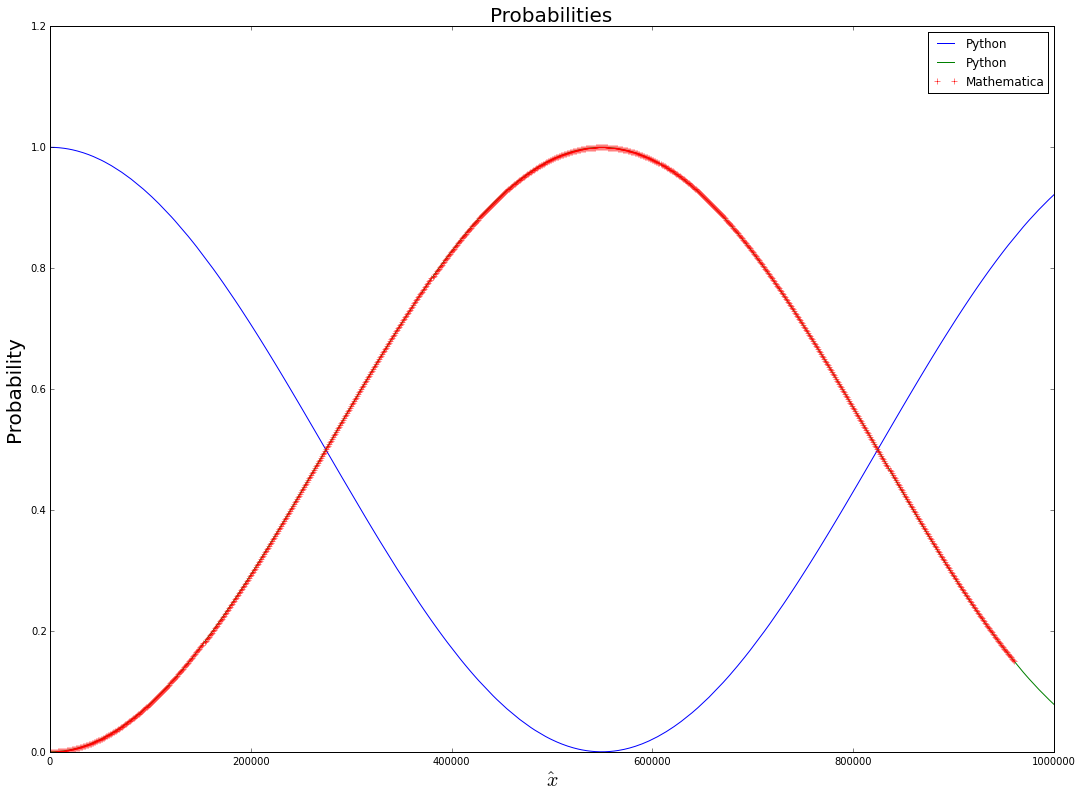

In [295]:
# Compare with Mathematica
mmaprobx=np.loadtxt("assets/matter-perturbatin-solver/reconstructsingleProb2Listx.csv",dtype=float)
mmaprob=np.loadtxt("assets/matter-perturbatin-solver/reconstructsingleProb2List.csv",dtype=float)

plt.figure(figsize=(18,13))

plt.plot(xlin, prob,'-',label="Python") #
plt.plot(mmaprobx,mmaprob,'r+',label="Mathematica") #
plt.title("Probabilities",fontsize=20)
plt.xlabel("$\hat x$",fontsize=20)
plt.ylabel("Probability",fontsize=20)
plt.legend()